## New **import the necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## **load and preprocess the CIFAR10 dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Split the training set into a new training set (80%) and a validation set (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


170498071/170498071 [==============================] - 5s 0us/step


## **Data Augmentation**

In [3]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

## **import the VGG16 and MobileNet models and remove their top layers**

In [4]:
# Import VGG16 model
vgg_model = tf.keras.applications.VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

# Remove top layers of VGG16 model
vgg_base = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)

# Import MobileNet model
mobile_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

# Remove top layers of MobileNet model
mobile_base = Model(inputs=mobile_model.input, outputs=mobile_model.layers[-2].output)


58889256/58889256 [==============================] - 1s 0us/step


17225924/17225924 [==============================] - 0s 0us/step


## **Add new top layers to the VGG16 and MobileNet models and compile them**

In [5]:
# Add new top layers to VGG16 model
vgg_output = vgg_base.output
vgg_output = Flatten()(vgg_output)
vgg_output = Dense(128, activation='relu')(vgg_output)
vgg_output = Dense(10, activation='softmax')(vgg_output)
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_output)

# Compile VGG16 model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add new top layers to MobileNet model
mobile_output = mobile_base.output
mobile_output = Flatten()(mobile_output)
mobile_output = Dense(128, activation='relu')(mobile_output)
mobile_output = Dense(10, activation='softmax')(mobile_output)
mobile_model = Model(inputs=mobile_base.input, outputs=mobile_output)

# Compile MobileNet model
mobile_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# **VGG16 transfer learning model**

### **We will freeze the initial layers of each model and train the remaining layers using transfer learning**

In [6]:
# Freeze initial layers of VGG16 model
for layer in vgg_base.layers:
    layer.trainable = False

# Train VGG16 model using transfer learning
vgg_history = vgg_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1250/1250 [==============================] - 68s 47ms/step - loss: 1.2135 - accuracy: 0.5701 - val_loss: 0.8139 - val_accuracy: 0.7214
Epoch 2/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.8689 - accuracy: 0.7022 - val_loss: 0.6724 - val_accuracy: 0.7738
Epoch 3/10
1250/1250 [==============================] - 44s 36ms/step - loss: 0.7545 - accuracy: 0.7417 - val_loss: 0.6073 - val_accuracy: 0.7887
Epoch 4/10
1250/1250 [==============================] - 43s 34ms/step - loss: 0.6818 - accuracy: 0.7656 - val_loss: 0.5258 - val_accuracy: 0.8185
Epoch 5/10
1250/1250 [==============================] - 43s 35ms/step - loss: 0.6258 - accuracy: 0.7853 - val_loss: 0.5047 - val_accuracy: 0.8262
Epoch 6/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.5755 - accuracy: 0.8042 - val_loss: 0.4758 - val_accuracy: 0.8399
Epoch 7/10
1250/1250 [==============================] - 43s 34ms/step - loss: 0.5445 - accuracy: 0.8137 - val_loss: 0.4568 -

# **MobileNet transfer learning model**

In [7]:
# Freeze initial layers of MobileNet model
for layer in mobile_base.layers:
    layer.trainable = False

# Train MobileNet model using transfer learning
mobile_history = mobile_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_val, y_val)
)


Epoch 1/10
1250/1250 [==============================] - 71s 45ms/step - loss: 2.5408 - accuracy: 0.3597 - val_loss: 1.4555 - val_accuracy: 0.5047
Epoch 2/10
1250/1250 [==============================] - 62s 49ms/step - loss: 1.5022 - accuracy: 0.4769 - val_loss: 1.2263 - val_accuracy: 0.5718
Epoch 3/10
1250/1250 [==============================] - 43s 34ms/step - loss: 1.3183 - accuracy: 0.5377 - val_loss: 1.0434 - val_accuracy: 0.6293
Epoch 4/10
1250/1250 [==============================] - 42s 34ms/step - loss: 1.1976 - accuracy: 0.5829 - val_loss: 1.0166 - val_accuracy: 0.6620
Epoch 5/10
1250/1250 [==============================] - 42s 34ms/step - loss: 1.1106 - accuracy: 0.6132 - val_loss: 0.9542 - val_accuracy: 0.6655
Epoch 6/10
1250/1250 [==============================] - 42s 33ms/step - loss: 1.0422 - accuracy: 0.6378 - val_loss: 0.7619 - val_accuracy: 0.7409
Epoch 7/10
1250/1250 [==============================] - 43s 34ms/step - loss: 0.9847 - accuracy: 0.6594 - val_loss: 0.7736 -

## **VGG16 Baseline Model**


In [8]:
vgg_baseline_output = Flatten()(vgg_model.output)
vgg_baseline_output = Dense(10, activation='softmax')(vgg_baseline_output)
vgg_baseline_model = Model(inputs=vgg_model.input, outputs=vgg_baseline_output)
vgg_baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_baseline_history = vgg_baseline_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
1250/1250 [==============================] - 36s 28ms/step - loss: 1.7731 - accuracy: 0.3595 - val_loss: 1.5279 - val_accuracy: 0.3912
Epoch 2/10
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2669 - accuracy: 0.5605 - val_loss: 1.0100 - val_accuracy: 0.6432
Epoch 3/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.8804 - accuracy: 0.7048 - val_loss: 0.7750 - val_accuracy: 0.7794
Epoch 4/10
1250/1250 [==============================] - 34s 27ms/step - loss: 0.6724 - accuracy: 0.8585 - val_loss: 0.6255 - val_accuracy: 0.8616
Epoch 5/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5723 - accuracy: 0.8640 - val_loss: 0.5627 - val_accuracy: 0.8641
Epoch 6/10
1250/1250 [==============================] - 34s 27ms/step - loss: 0.5178 - accuracy: 0.8651 - val_loss: 0.5141 - val_accuracy: 0.8628
Epoch 7/10
1250/1250 [==============================] - 34s 28ms/step - loss: 0.4864 - accuracy: 0.8653 - val_loss: 0.4864 -

## **MobileNet Baseline Model**

In [9]:
mobile_baseline_output = Flatten()(mobile_model.output)
mobile_baseline_output = Dense(10, activation='softmax')(mobile_baseline_output)
mobile_baseline_model = Model(inputs=mobile_model.input, outputs=mobile_baseline_output)
mobile_baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobile_baseline_history = mobile_baseline_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test)
)


Epoch 1/10
1250/1250 [==============================] - 35s 26ms/step - loss: 1.8171 - accuracy: 0.3303 - val_loss: 1.6420 - val_accuracy: 0.3567
Epoch 2/10
1250/1250 [==============================] - 32s 25ms/step - loss: 1.5643 - accuracy: 0.3827 - val_loss: 1.4076 - val_accuracy: 0.5045
Epoch 3/10
1250/1250 [==============================] - 32s 25ms/step - loss: 1.3031 - accuracy: 0.5245 - val_loss: 1.1504 - val_accuracy: 0.6099
Epoch 4/10
1250/1250 [==============================] - 32s 26ms/step - loss: 1.1371 - accuracy: 0.6183 - val_loss: 1.0304 - val_accuracy: 0.6588
Epoch 5/10
1250/1250 [==============================] - 32s 26ms/step - loss: 1.0490 - accuracy: 0.6653 - val_loss: 1.0102 - val_accuracy: 0.7245
Epoch 6/10
1250/1250 [==============================] - 32s 25ms/step - loss: 0.9853 - accuracy: 0.7107 - val_loss: 0.9632 - val_accuracy: 0.7272
Epoch 7/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.9288 - accuracy: 0.7269 - val_loss: 0.8691 -

### **Evaluate the models on the test set and compare their performance**

In [10]:
# Evaluate VGG16 model on test set
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(x_test, y_test)
print('VGG16 Test Accuracy:', vgg_test_acc)

# Evaluate MobileNet model on test set
mobile_test_loss, mobile_test_acc = mobile_model.evaluate(x_test, y_test)
print('MobileNet Test Accuracy:', mobile_test_acc)


313/313 [==============================] - 3s 9ms/step - loss: 9.2802 - accuracy: 0.3621
VGG16 Test Accuracy: 0.3621000051498413
313/313 [==============================] - 2s 5ms/step - loss: 9.7208 - accuracy: 0.2168
MobileNet Test Accuracy: 0.2168000042438507


## **Evaluate baseline models**

In [11]:
vgg_baseline_loss, vgg_baseline_accuracy = vgg_baseline_model.evaluate(x_test, y_test)
mobile_baseline_loss, mobile_baseline_accuracy = mobile_baseline_model.evaluate(x_test, y_test)

print("VGG16 Baseline Accuracy:", vgg_baseline_accuracy)
print("MobileNet Baseline Accuracy:", mobile_baseline_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.8075 - accuracy: 0.7544
VGG16 Baseline Accuracy: 0.866100013256073
MobileNet Baseline Accuracy: 0.7544000148773193


## **Performance Comparison**

In [13]:
# Calculate evaluation metrics for VGG16 baseline model
vgg_baseline_pred = np.argmax(vgg_baseline_model.predict(x_test), axis=-1)
vgg_baseline_precision = precision_score(np.argmax(y_test, axis=-1), vgg_baseline_pred, average='weighted')
vgg_baseline_recall = recall_score(np.argmax(y_test, axis=-1), vgg_baseline_pred, average='weighted')
vgg_baseline_f1 = f1_score(np.argmax(y_test, axis=-1), vgg_baseline_pred, average='weighted')

# Calculate evaluation metrics for VGG16 transfer learning model
vgg_pred = np.argmax(vgg_model.predict(x_test), axis=-1)
vgg_precision = precision_score(np.argmax(y_test, axis=-1), vgg_pred, average='weighted')
vgg_recall = recall_score(np.argmax(y_test, axis=-1), vgg_pred, average='weighted')
vgg_f1 = f1_score(np.argmax(y_test, axis=-1), vgg_pred, average='weighted')

# Calculate evaluation metrics for MobileNet baseline model
mobile_baseline_pred = np.argmax(mobile_baseline_model.predict(x_test), axis=-1)
mobile_baseline_precision = precision_score(np.argmax(y_test, axis=-1), mobile_baseline_pred, average='weighted')
mobile_baseline_recall = recall_score(np.argmax(y_test, axis=-1), mobile_baseline_pred, average='weighted')
mobile_baseline_f1 = f1_score(np.argmax(y_test, axis=-1), mobile_baseline_pred, average='weighted')

# Calculate evaluation metrics for MobileNet transfer learning model
mobile_pred = np.argmax(mobile_model.predict(x_test), axis=-1)
mobile_precision = precision_score(np.argmax(y_test, axis=-1), mobile_pred, average='weighted')
mobile_recall = recall_score(np.argmax(y_test, axis=-1), mobile_pred, average='weighted')
mobile_f1 = f1_score(np.argmax(y_test, axis=-1), mobile_pred, average='weighted')

# Print evaluation metrics for comparison
print("VGG16 Baseline Metrics:")
print("Precision: {:.4f}".format(vgg_baseline_precision))
print("Recall: {:.4f}".format(vgg_baseline_recall))
print("F1-Score: {:.4f}".format(vgg_baseline_f1))
print("\nVGG16 Transfer Learning Metrics:")
print("Precision: {:.4f}".format(vgg_precision))
print("Recall: {:.4f}".format(vgg_recall))
print("F1-Score: {:.4f}".format(vgg_f1))

print("\nMobileNet Baseline Metrics:")
print("Precision: {:.4f}".format(mobile_baseline_precision))
print("Recall: {:.4f}".format(mobile_baseline_recall))
print("F1-Score: {:.4f}".format(mobile_baseline_f1))
print("\nMobileNet Transfer Learning Metrics:")
print("Precision: {:.4f}".format(mobile_precision))
print("Recall: {:.4f}".format(mobile_recall))
print("F1-Score: {:.4f}".format(mobile_f1))

313/313 [==============================] - 3s 11ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step
VGG16 Baseline Metrics:
Precision: 0.8661
Recall: 0.8661
F1-Score: 0.8651

VGG16 Transfer Learning Metrics:
Precision: 0.3076
Recall: 0.3621
F1-Score: 0.3292

MobileNet Baseline Metrics:
Precision: 0.7572
Recall: 0.7544
F1-Score: 0.7493

MobileNet Transfer Learning Metrics:
Precision: 0.1903
Recall: 0.2168
F1-Score: 0.2007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Visualization**

313/313 [==============================] - 2s 7ms/step


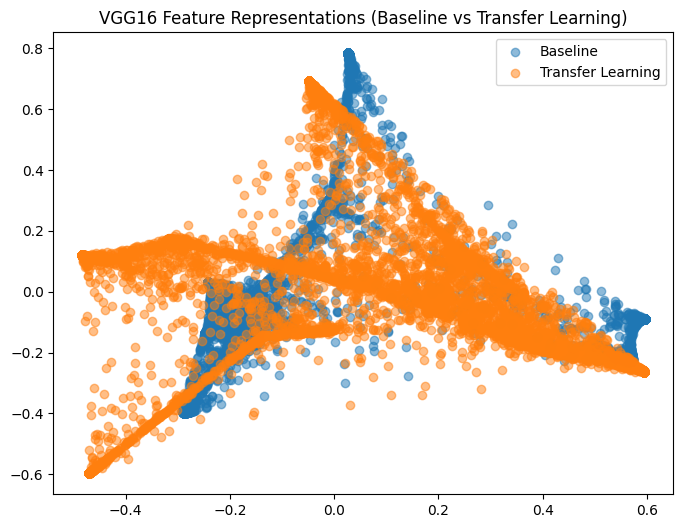

313/313 [==============================] - 1s 4ms/step


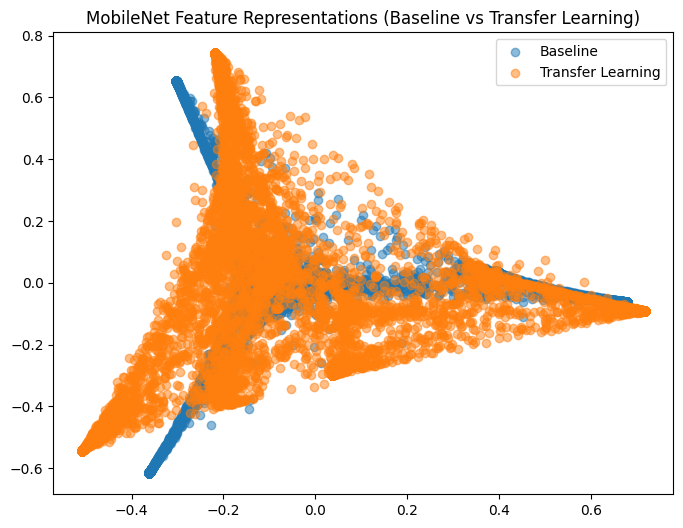

In [14]:
# Extract features from VGG16 baseline model
vgg_baseline_features = vgg_baseline_model.predict(x_test)
vgg_baseline_features = vgg_baseline_features.reshape((vgg_baseline_features.shape[0], -1))

# Apply PCA to VGG16 baseline features
pca_vgg_baseline = PCA(n_components=2)
vgg_baseline_pca = pca_vgg_baseline.fit_transform(vgg_baseline_features)

# Extract features from VGG16 transfer learning model
vgg_features = vgg_model.predict(x_test)
vgg_features = vgg_features.reshape((vgg_features.shape[0], -1))

# Apply PCA to VGG16 transfer learning features
pca_vgg = PCA(n_components=2)
vgg_pca = pca_vgg.fit_transform(vgg_features)

# Plot VGG16 baseline and transfer learning features
plt.figure(figsize=(8, 6))
plt.scatter(vgg_baseline_pca[:, 0], vgg_baseline_pca[:, 1], label='Baseline', alpha=0.5)
plt.scatter(vgg_pca[:, 0], vgg_pca[:, 1], label='Transfer Learning', alpha=0.5)
plt.legend()
plt.title('VGG16 Feature Representations (Baseline vs Transfer Learning)')
plt.show()

# Extract features from MobileNet baseline model
mobile_baseline_features = mobile_baseline_model.predict(x_test)
mobile_baseline_features = mobile_baseline_features.reshape((mobile_baseline_features.shape[0], -1))

# Apply PCA to MobileNet baseline features
pca_mobile_baseline = PCA(n_components=2)
mobile_baseline_pca = pca_mobile_baseline.fit_transform(mobile_baseline_features)

# Extract features from MobileNet transfer learning model
mobile_features = mobile_model.predict(x_test)
mobile_features = mobile_features.reshape((mobile_features.shape[0], -1))

# Apply PCA to MobileNet transfer learning features
pca_mobile = PCA(n_components=2)
mobile_pca = pca_mobile.fit_transform(mobile_features)

# Plot MobileNet baseline and transfer learning features
plt.figure(figsize=(8, 6))
plt.scatter(mobile_baseline_pca[:, 0], mobile_baseline_pca[:, 1], label='Baseline', alpha=0.5)
plt.scatter(mobile_pca[:, 0], mobile_pca[:, 1], label='Transfer Learning', alpha=0.5)
plt.legend()
plt.title('MobileNet Feature Representations (Baseline vs Transfer Learning)')
plt.show()